Packages

In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

Data to create graphs

In [2]:
final_dataframes = pickle.load(open("final_dataframes.pkl", "rb"))

In [3]:
# Define the train ratio
train_ratio = 0.7  # 80% training data
lookback = 50
pred_horizon = 5
df_dict = final_dataframes

# Split each DataFrame into training and testing parts based on time
df_dict_train = {}
df_dict_test = {}
for key, df in final_dataframes.items():
    n_time_steps = len(df['traffic_flow'])
    train_size = int(n_time_steps * train_ratio)
    df_train = df.iloc[:train_size].copy()
    df_test = df.iloc[train_size:].copy()
    df_dict_train[key] = df_train
    df_dict_test[key] = df_test


def create_sliding_window_data(df_dict, lookback, pred_horizon):
    X_dict = {}
    y_dict = {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node = []
        y_node = []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i + lookback])  # Input: Lookback window
            y_node.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict

# Generate sliding window data for training and testing sets
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)



In [4]:
def clean_graph(graph):
    # Remove self-loops
    graph = graph.copy()  # Avoid modifying the
    self_loops = list(nx.selfloop_edges(graph))
    graph.remove_edges_from(self_loops)
    
    # Remove duplicate edges (not necessary for undirected graphs in NetworkX)
    # Here just in case your graph is directed or you need further verification
    edges_to_remove = []
    for u, v, data in graph.edges(data=True):
        if graph.number_of_edges(u, v) > 1:  # More than one edge exists
            edges_to_remove.append((u, v))
    
    graph.remove_edges_from(edges_to_remove)
    largest_component = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_component)

    print(f"Removed {len(self_loops)} self-loops and {len(edges_to_remove)} duplicate edges. Choose the Largest Component: {len(largest_component)} nodes.")
    # extract largest component

    return graph

def create_correlation_graph(df_dict_full, df_dict_train, threshold=0.5, weighted=False,degree=4):
    """
    Create a correlation graph with a maximum degree constraint using only the training data for correlations.
    """
    correlation_graph = nx.Graph()
    correlations_dict = {}

    # Add nodes to the graph using the full data
    for key, df in df_dict_full.items():
        correlation_graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow=df['traffic_flow'].values  # Full traffic data
        )

    # Calculate correlations using the training data
    for key1, df1_train in df_dict_train.items():
        for key2, df2_train in df_dict_train.items():
            if key1 >= key2:  # Avoid duplicate computations
                continue
            correlation = np.corrcoef(df1_train['traffic_flow'], df2_train['traffic_flow'])[0, 1]
            correlations_dict[key1, key2] = correlation
            correlations_dict[key2, key1] = correlation  # Symmetric for undirected graph

    # Add edges based on correlation, enforcing degree constraint
    for key1 in df_dict_full.keys():
        # Sort potential connections by correlation (highest first)
        potential_edges = [
            (key2, correlations_dict[key1, key2])
            for key2 in df_dict_full.keys() if key1 != key2 and (key1, key2) in correlations_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])  # Sort by descending correlation

        for key2, corr in potential_edges:
            if correlation_graph.degree[key1] < degree and correlation_graph.degree[key2] < degree:
                if corr > threshold:
                    if weighted:
                        correlation_graph.add_edge(key1, key2, weight=corr)
                    else:
                        correlation_graph.add_edge(key1, key2)

    # Clean graph
    correlation_graph = clean_graph(correlation_graph)
    return correlation_graph, correlations_dict

def create_distance_graph(df_dict, weighted=False, degree=4):
    """
    Create a distance graph with a maximum degree constraint.
    """
    distance_graph = nx.Graph()
    distance_dict = {}

    # Add nodes to the graph
    for key, df in df_dict.items():
        distance_graph.add_node(
            key, 
            x=df['Xkoordinat'].iloc[0], 
            y=df['Ykoordinat'].iloc[0], 
            traffic_flow=df['traffic_flow'].values
        )

    # Calculate distances and store in a dictionary
    for key1, df1 in df_dict.items():
        for key2, df2 in df_dict.items():
            if key1 == key2:
                continue
            idx = df1['traffic_flow'].first_valid_index()
            distance = math.sqrt(
                (df1['Xkoordinat'][idx] - df2['Xkoordinat'][idx])**2 +
                (df1['Ykoordinat'][idx] - df2['Ykoordinat'][idx])**2
            )
            distance_dict[key1, key2] = distance

    # Add edges based on distance, enforcing degree constraint
    threshold = (sum(distance_dict.values()) / len(distance_dict)) * 2  # Distance threshold
    for key1 in df_dict.keys():
        # Sort potential connections by distance (shortest first)
        potential_edges = [
            (key2, distance_dict[key1, key2])
            for key2 in df_dict.keys() if key1 != key2 and (key1, key2) in distance_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: x[1])  # Sort by ascending distance
        
        for key2, dist in potential_edges:
            if distance_graph.degree[key1] < degree and distance_graph.degree[key2] < degree:
                if dist < threshold:
                    if weighted:
                        max_distance = max(distance_dict.values())
                        min_distance = min(distance_dict.values())
                        normalised_distance = (dist - min_distance) / (max_distance - min_distance)
                        distance_graph.add_edge(key1, key2, weight=normalised_distance)
                    else:
                        distance_graph.add_edge(key1, key2)

    # Clean graph
    distance_graph = clean_graph(distance_graph)
    return distance_graph, distance_dict

def create_fully_connected_graph(df_dict):
    # Connect every node to every other node without weights 
    fully_connected_graph = nx.complete_graph(len(df_dict))

    # Add attributes to the nodes
    for i, (key, df) in enumerate(df_dict.items()):
        fully_connected_graph.nodes[i]['x'] = df['Xkoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['y'] = df['Ykoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['traffic_flow'] = df['traffic_flow'].values
        
    return fully_connected_graph

def create_fully_connected_graph_RANDOM_WEIGHTS(df_dict):
    # Connect every node to every other node without weights 
    fully_connected_graph = nx.complete_graph(len(df_dict))

    # Add attributes to the nodes
    for i, (key, df) in enumerate(df_dict.items()):
        fully_connected_graph.nodes[i]['x'] = df['Xkoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['y'] = df['Ykoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['traffic_flow'] = df['traffic_flow'].values

    # Add random weights to the edges
    for u, v in fully_connected_graph.edges:
        fully_connected_graph[u][v]['weight'] = np.random.rand()
        
    return fully_connected_graph, nx.get_edge_attributes(fully_connected_graph, 'weight')

distance_graph_weighted, distance_dict = create_distance_graph(final_dataframes, weighted=True, degree=4)
distance_graph_unweighted, _ = create_distance_graph(final_dataframes, weighted=False, degree=4)

correlation_graph_weighted, correlation_dict = create_correlation_graph(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.7, weighted=True, degree=10)
correlation_graph_unweighted, _ = create_correlation_graph(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.7, weighted=False, degree=10)

fully_connected_graph = create_fully_connected_graph(final_dataframes)
fully_connected_graph_RANDOM_WEIGHTS, fully_connected_weights = create_fully_connected_graph_RANDOM_WEIGHTS(final_dataframes)


Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 26 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 26 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 25 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 25 nodes.


Plot Graphs if wanted

In [5]:
# # Plot the Correlation graph without labels or edge attributes, use a spring layout, with a title that explain how they where plotted
# plt.figure(figsize=(6, 6))
# plt.title("Correlation Graph with Spring Layout")
# pos = nx.spring_layout(correlation_graph_weighted)
# nx.draw(correlation_graph_weighted, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
# plt.show()

# # Extract positions from the graph's node attributes
# pos = {node: (data['x'], data['y']) for node, data in distance_graph_weighted.nodes(data=True)}
# x_values = [coord[0] for coord in pos.values()]
# y_values = [coord[1] for coord in pos.values()]
# plt.figure(figsize=(8, 8))
# plt.title("Distance Graph with Geographic Layout", fontsize=14)


# plt.grid(True, linestyle='--', alpha=0.5)
# plt.scatter(x_values, y_values, c='blue', s=50, label='Nodes')
# for edge in distance_graph_weighted.edges():
#     x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
#     y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
#     plt.plot(x_coords, y_coords, color='gray', alpha=0.7)
# plt.xlabel("X Coordinate", fontsize=12)
# plt.ylabel("Y Coordinate", fontsize=12)
# plt.legend()
# plt.show()


# # Plot the Correlation graph without labels or edge attributes, use a spring layout, with a title that explain how they where plotted
# plt.figure(figsize=(6, 6))
# plt.title("Fully Connected Graph with Spring Layout")
# pos = nx.spring_layout(fully_connected_graph)
# nx.draw(fully_connected_graph, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
# plt.show()

## Model Section

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


Create Data

In [7]:

# Prepare sliding window data
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)

# Combine data from all nodes
X_train_list = []
y_train_list = []
for key in X_train_dict:
    X_train_list.append(X_train_dict[key])
    y_train_list.append(y_train_dict[key])

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

X_test_list = []
y_test_list = []
for key in X_test_dict:
    X_test_list.append(X_test_dict[key])
    y_test_list.append(y_test_dict[key])

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)

X_val = torch.tensor(X_val, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.float)

X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

# Prepare graph edges with integer mapping
node_mapping = {node: idx for idx, node in enumerate(correlation_graph_weighted.nodes())}

edge_index = torch.tensor(
    [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in correlation_graph_weighted.edges],
    dtype=torch.long
).t().contiguous()

# Create PyTorch Geometric Data objects
train_data = Data(x=X_train, edge_index=edge_index, y=y_train.view(-1, pred_horizon))
val_data = Data(x=X_val, edge_index=edge_index, y=y_val.view(-1, pred_horizon))
test_data = Data(x=X_test, edge_index=edge_index, y=y_test.view(-1, pred_horizon))


Helper Function to create train and test dataset in a deterministic way

In [8]:
# We should really explain what these functions do, since we dont use random test train split longer
def split_dataframes(df_dict, train_ratio=0.8):
    """
    Splits each DataFrame in df_dict into training and testing parts based on time indices.

    Returns:
        df_dict_train: Dictionary of training DataFrames.
        df_dict_test: Dictionary of testing DataFrames.
    """
    df_dict_train = {}
    df_dict_test = {}
    for key, df in df_dict.items():
        n_time_steps = len(df['traffic_flow'])
        train_size = int(n_time_steps * train_ratio)
        df_train = df.iloc[:train_size].copy()
        df_test = df.iloc[train_size:].copy()
        df_dict_train[key] = df_train
        df_dict_test[key] = df_test
    return df_dict_train, df_dict_test

def combine_node_data(X_dict, y_dict):
    """
    Combines data from all nodes.

    Returns:
        X_combined: Combined input sequences from all nodes.
        y_combined: Combined target sequences from all nodes.
    """
    X_list = []
    y_list = []
    for key in X_dict:
        X_list.append(X_dict[key])
        y_list.append(y_dict[key])
    X_combined = np.concatenate(X_list, axis=0)
    y_combined = np.concatenate(y_list, axis=0)
    return X_combined, y_combined

def convert_to_tensors_and_split(X, y, val_ratio=0.1, random_state=42):
    """
    Converts data to PyTorch tensors and splits into train and validation sets.

    Returns:
        X_train: Training input tensor.
        X_val: Validation input tensor.
        y_train: Training target tensor.
        y_val: Validation target tensor.
    """
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.float)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_tensor, y_tensor, test_size=val_ratio, random_state=random_state
    )
    return X_train, X_val, y_train, y_val

def prepare_pyg_data(X_train, y_train, X_val, y_val, X_test, y_test, edge_index, pred_horizon):
    """
    Prepares PyTorch Geometric Data objects for training, validation, and testing.

    Returns:
        train_data: Data object for training.
        val_data: Data object for validation.
        test_data: Data object for testing.
    """
    train_data = Data(x=X_train, edge_index=edge_index, y=y_train.view(-1, pred_horizon))
    val_data = Data(x=X_val, edge_index=edge_index, y=y_val.view(-1, pred_horizon))
    test_data = Data(x=X_test, edge_index=edge_index, y=y_test.view(-1, pred_horizon))
    return train_data, val_data, test_data



In [9]:
# Define GNN model
class Baseline(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.fc(x)
        return x

class ImprovedBaseline(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class Baseline_updatet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = self.fc(x)
        return x


# Define GNN model
class TrafficGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = self.fc(x)
        return x


In [10]:
# Initialize model, optimizer, and loss function
hc = 32
#model = Baseline_updatet(in_channels=lookback, hidden_channels=hc, out_channels=pred_horizon, dropout_rate=0.5)
model = TrafficGCN(in_channels=lookback, hidden_channels=hc, out_channels=pred_horizon)
optimizer = Adam(model.parameters(), lr=0.01, amsgrad=False)
criterion = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, cooldown=10)

# Early stopping parameters
early_stopping_patience = 50
best_val_loss = float('inf')
epochs_no_improve = 0

# Initialize lists to store training and validation losses and metrics
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_rmses = []
val_rmses = []

# Lists to store actual and predicted values for plotting
actual_values = []
predicted_values = []


# Training loop with validation and early stopping
model.train()
print("Lookback: ", lookback, " Pred Horizon: ", pred_horizon, " Hidden Channels: ", hc)
for epoch in range(1_000):
    optimizer.zero_grad()
    
    # Forward pass on training data
    out = model(train_data)
    train_loss = criterion(out, train_data.y)
    train_rmse = torch.sqrt(train_loss).item()
    train_mae = torch.mean(torch.abs(out - train_data.y)).item()
    
    # Backward pass
    train_loss.backward()
    optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_out = model(val_data)
        val_loss = criterion(val_out, val_data.y)
        val_rmse = torch.sqrt(val_loss).item()
        val_mae = torch.mean(torch.abs(val_out - val_data.y)).item()

        # Store actual and predicted values after each epoch
        actual_values = val_data.y.cpu().numpy()
        predicted_values = val_out.cpu().numpy()
    
    model.train()  # Switch back to training mode

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Store losses and metrics for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_maes.append(train_mae)
    val_maes.append(val_mae)
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
    
    # Early stopping check
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Print loss and metrics every 10 epochs
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, LR: { optimizer.param_groups[0]['lr']:.6f}, Train Loss: {train_loss.item():.2f}, "
              f"Val Loss: {val_loss.item():.2f}, Train MAE: {train_mae:.2f}, "
              f"Val MAE: {val_mae:.2f}")

Lookback:  50  Pred Horizon:  5  Hidden Channels:  32
Epoch 0, LR: 0.010000, Train Loss: 4246.15, Val Loss: 2936.89, Train MAE: 34.29, Val MAE: 27.10
Epoch 1, LR: 0.010000, Train Loss: 2999.92, Val Loss: 1798.97, Train MAE: 27.26, Val MAE: 23.45
Epoch 2, LR: 0.010000, Train Loss: 1839.57, Val Loss: 2471.72, Train MAE: 23.54, Val MAE: 28.52
Epoch 3, LR: 0.010000, Train Loss: 2484.60, Val Loss: 1282.04, Train MAE: 28.60, Val MAE: 20.15
Epoch 4, LR: 0.010000, Train Loss: 1310.03, Val Loss: 1192.92, Train MAE: 20.24, Val MAE: 17.06
Epoch 5, LR: 0.010000, Train Loss: 1233.55, Val Loss: 1236.30, Train MAE: 17.17, Val MAE: 17.05
Epoch 6, LR: 0.010000, Train Loss: 1279.85, Val Loss: 952.08, Train MAE: 17.16, Val MAE: 14.92
Epoch 7, LR: 0.010000, Train Loss: 987.91, Val Loss: 695.11, Train MAE: 15.04, Val MAE: 13.68
Epoch 8, LR: 0.010000, Train Loss: 711.45, Val Loss: 985.08, Train MAE: 13.76, Val MAE: 17.83
Epoch 9, LR: 0.010000, Train Loss: 972.60, Val Loss: 766.13, Train MAE: 17.79, Val MAE:

In [11]:
# Eval model
model.eval()
test_out = model(test_data)
test_loss = criterion(test_out, test_data.y)
test_rmse = torch.sqrt(test_loss).item()
test_mae = torch.mean(torch.abs(test_out - test_data.y)).item()
print(f"Test Loss: {test_loss.item():.2f}, Test MAE: {test_mae:.2f}, Test RMSE: {test_rmse:.2f}")


Test Loss: 138.08, Test MAE: 6.28, Test RMSE: 11.75


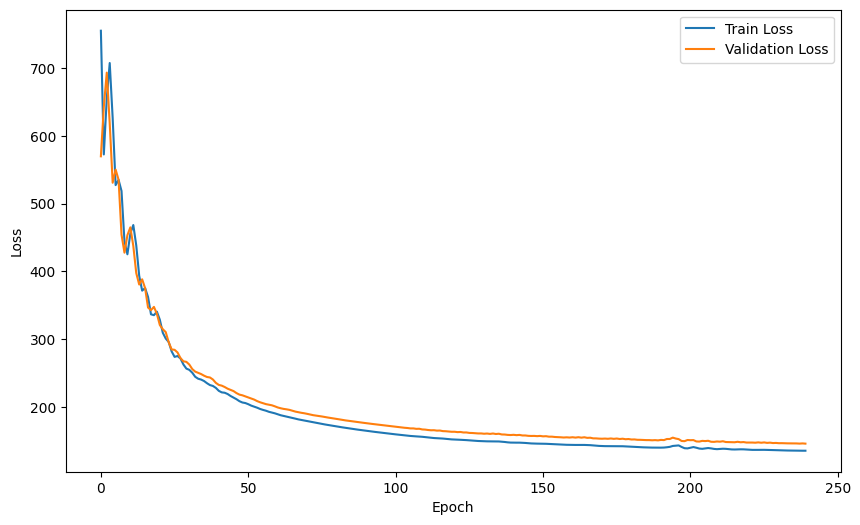

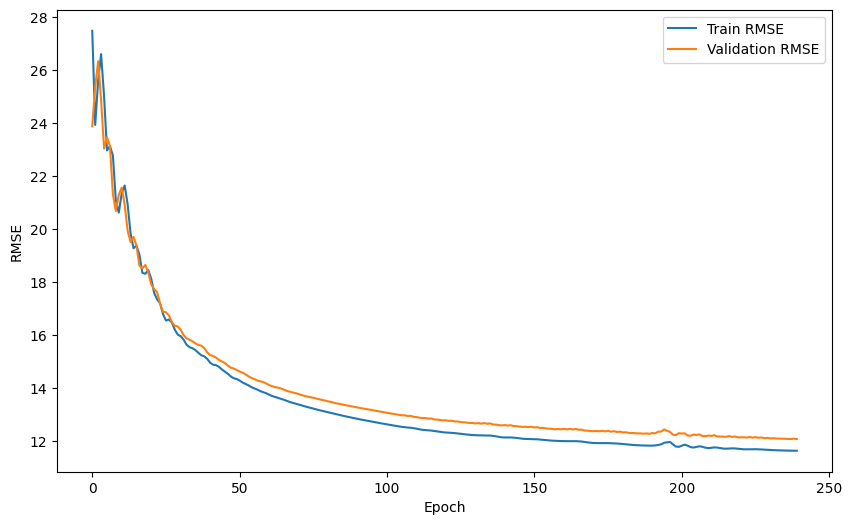

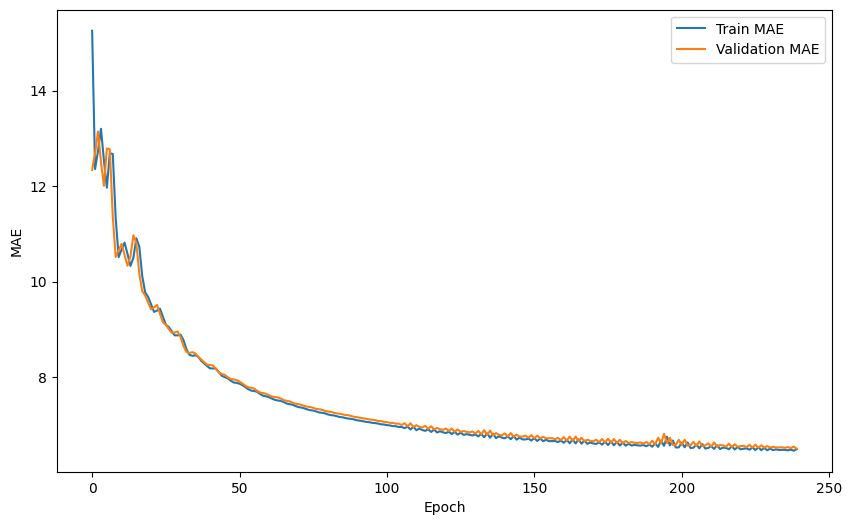

In [12]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses[10:250], label='Train Loss')
plt.plot(val_losses[10:250], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation RMSE
plt.figure(figsize=(10, 6))
plt.plot(train_rmses[10:250], label='Train RMSE')  
plt.plot(val_rmses[10:250], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(train_maes[10:250], label='Train MAE')
plt.plot(val_maes[10:250], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

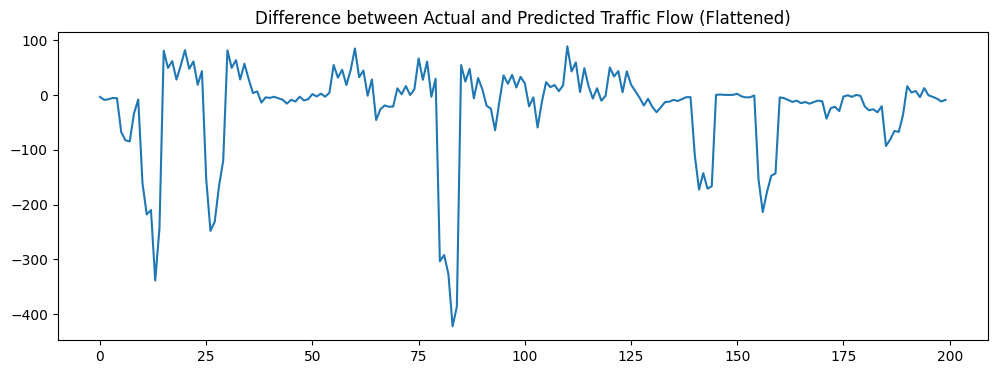

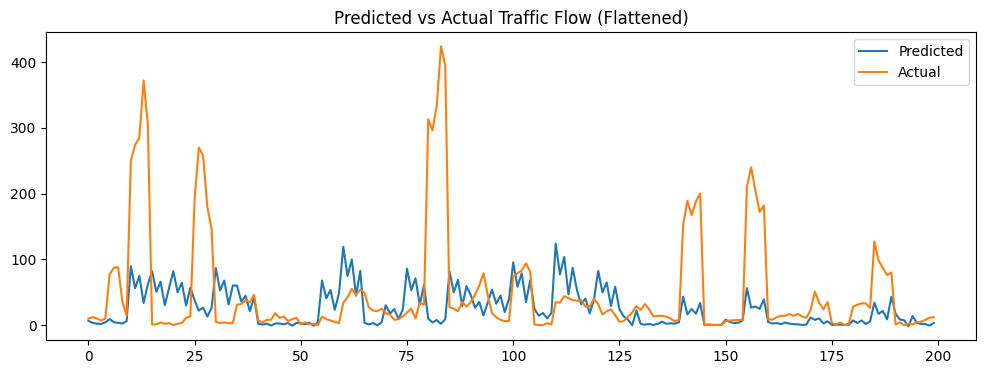

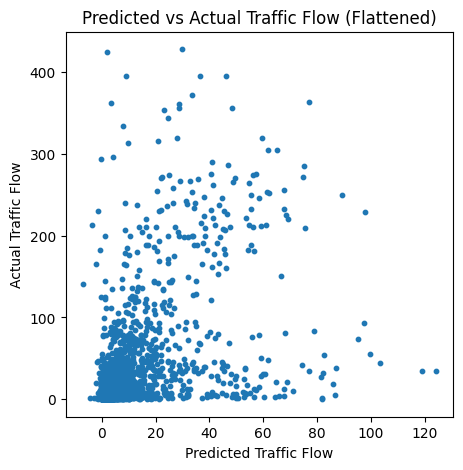

In [13]:
# Convert actual and predicted values to numpy arrays for plotting
actual_values_stack = np.vstack(actual_values)
predicted_values_stack = np.vstack(predicted_values)

# Flatten the predicted and actual values
actual_values_flat = actual_values_stack.reshape(-1)
predicted_values_flat = predicted_values_stack.reshape(-1)

# Plot the difference between actual and predicted values
plt.figure(figsize=(12, 4))
plt.title("Difference between Actual and Predicted Traffic Flow (Flattened)")
plt.plot(predicted_values_flat[0:200] - actual_values_flat[0:200])
plt.show()

# Plot predicted vs actual traffic flow
plt.figure(figsize=(12, 4))
plt.title("Predicted vs Actual Traffic Flow (Flattened)")
plt.plot(predicted_values_flat[0:200], label='Predicted')
plt.plot(actual_values_flat[0:200], label='Actual')
plt.legend()
plt.show()

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(predicted_values_flat[:2000], actual_values_flat[:2000], s=10)
plt.xlabel('Predicted Traffic Flow')
plt.ylabel('Actual Traffic Flow')
plt.title('Predicted vs Actual Traffic Flow (Flattened)')
plt.show()


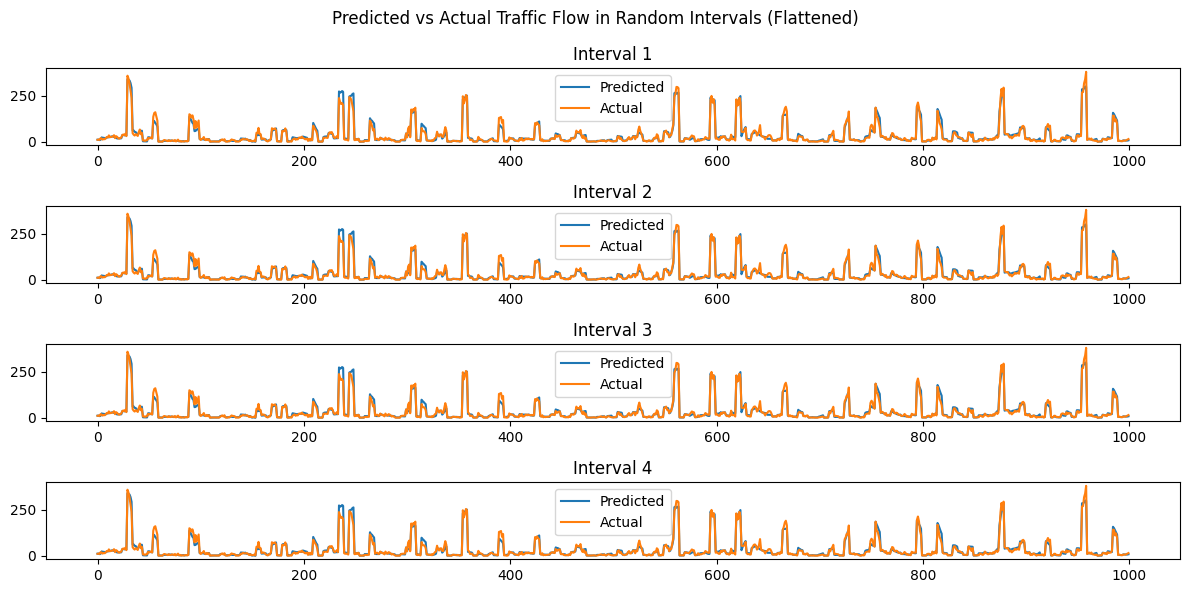

In [14]:
# Flatten the sequences
actual_values_flat = actual_values_stack.reshape(-1)
predicted_values_flat = predicted_values_stack.reshape(-1)

# Make 4 subplots showing 4 randomly chosen intervals of 250 predictions
fig, axs = plt.subplots(4, 1, figsize=(12, 6))
fig.suptitle('Predicted vs Actual Traffic Flow in Random Intervals (Flattened)')

interval_length = 1000  # You can adjust this value
start = np.random.randint(0, len(predicted_values_flat) - interval_length)
for i, ax in enumerate(axs.flat):
    
    end = start + interval_length

    ax.plot(predicted_values_flat[start:end], label='Predicted')
    ax.plot(actual_values_flat[start:end], label='Actual')
    ax.set_title(f'Interval {i+1}')
    ax.legend()

plt.tight_layout()
plt.show()
